In [28]:
from collections import defaultdict, Counter
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sn
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [2]:
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
main_df = pd.read_pickle('main_df_sampled.pickle')


In [29]:
# Combine 'title' and 'selftext' fields for text analysis
text_df = main_df['title'].map(str) + " " + main_df['selftext']
y = pd.get_dummies(main_df['genre'])


In [30]:
# Set parameters for the TF-IDF
MAX_FEATURES = 10000  # Set to the desired vocabulary size
MAX_SEQUENCE_LENGTH = 500  # Limit the length of sequences

In [31]:
tfidf_vectorizer = TfidfVectorizer(max_features=MAX_FEATURES, stop_words='english')


In [32]:
X_tfidf = tfidf_vectorizer.fit_transform(text_df)
feature_names = tfidf_vectorizer.get_feature_names_out()

In [33]:
X_tfidf_dense = X_tfidf.toarray()

In [34]:
word_index = {word: index + 1 for index, word in enumerate(feature_names)}


In [35]:
def text_to_sequence(text):
    return [word_index.get(word, 0) for word in text.split()]

In [36]:
sequences = [text_to_sequence(sentence) for sentence in text_df]


In [37]:
X_sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)


In [38]:
model = Sequential()
model.add(Embedding(len(word_index) + 1, 100, input_length=MAX_SEQUENCE_LENGTH))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(y.shape[1], activation='softmax'))

In [39]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])


In [40]:
X_train, X_test, y_train, y_test = train_test_split(X_sequences, y, test_size=0.2, random_state=42)


In [41]:
history = model.fit(X_train, y_train, batch_size=64, epochs=5, validation_data=(X_test, y_test))


Epoch 1/5
1463/1463 [==============================] - 2172s 1s/step - loss: 3.3553 - accuracy: 0.0877 - val_loss: 2.8734 - val_accuracy: 0.1841
Epoch 2/5
1463/1463 [==============================] - 2124s 1s/step - loss: 2.7331 - accuracy: 0.2241 - val_loss: 2.4114 - val_accuracy: 0.3140
Epoch 3/5
1463/1463 [==============================] - 2120s 1s/step - loss: 2.1004 - accuracy: 0.4082 - val_loss: 1.9398 - val_accuracy: 0.4777
Epoch 4/5
1463/1463 [==============================] - 2094s 1s/step - loss: 1.7033 - accuracy: 0.5377 - val_loss: 1.7035 - val_accuracy: 0.5578
Epoch 5/5
1463/1463 [==============================] - 2188s 1s/step - loss: 1.4683 - accuracy: 0.6096 - val_loss: 1.5957 - val_accuracy: 0.5910


In [42]:
# Evaluate the model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test.values, axis=1)

732/732 [==============================] - 107s 145ms/step


In [43]:
model.save('lstm_cnn_tfidf_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [46]:
def output_metrics(y_true, y_pred, normalize_cm=False, title_cm=None):
    report = classification_report(y_true, y_pred, output_dict=True)
    macro_avg = report['macro avg']
    weighted_avg = report['weighted avg']

    print('Balanced Accuracy:', balanced_accuracy_score(y_true, y_pred))
    print('Accuracy:', report['accuracy'])
    print('\t\t precision\t\t recall\t\t\t f1-score\t\t support')
    print('Macro Avg: \t {}\t {}\t {}\t {}'.format(
        macro_avg['precision'], macro_avg['recall'], macro_avg['f1-score'], macro_avg['support']))
    print('Weighted Avg: \t {}\t {}\t {}\t {}'.format(
        weighted_avg['precision'], weighted_avg['recall'], weighted_avg['f1-score'], weighted_avg['support']))
    plot_confusion_matrix(y_true, y_pred, normalize=normalize_cm, title=title_cm)


In [45]:
def plot_confusion_matrix(y_true, y_pred, normalize=False, title=None):
    data = confusion_matrix(y_true, y_pred)
    if normalize:
        data = data.astype('float') / data.sum(axis=1)[:, np.newaxis]
    df_cm = pd.DataFrame(data, index=np.unique(y_true), columns=np.unique(y_true))
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    plt.figure(figsize=(10, 7))
    if title:
        plt.title(title)
    else:
        plt.title("Confusion Matrix")
    sn.set(font_scale=1.4)
    sn.heatmap(df_cm, cmap='Reds')

Balanced Accuracy: 0.5924644167569445
Accuracy: 0.590982905982906
		 precision		 recall			 f1-score		 support
Macro Avg: 	 0.5907569682402087	 0.5924644167569445	 0.5878569924871856	 23400
Weighted Avg: 	 0.5902996940950271	 0.590982905982906	 0.5868935818652401	 23400


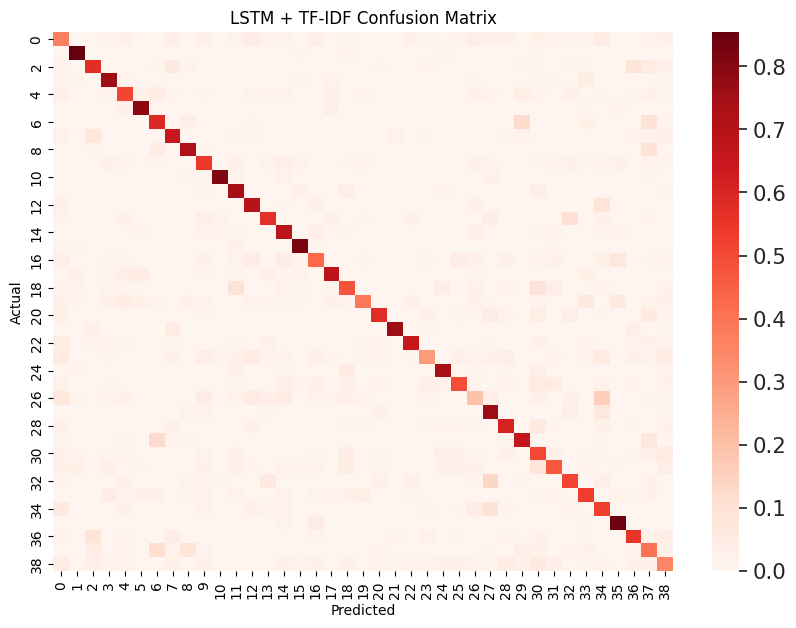

In [47]:
output_metrics(y_test_classes, y_pred_classes, normalize_cm=True, title_cm='LSTM + TF-IDF Confusion Matrix')


In [ ]:
`